In [ ]:
based on current trends you are familiar with, what should be peak learning rate and miniimum learning rate for a llama3 model with around 200M parameters
len_train_loader = 4781060
batch_size = 4

# number of total iterations
max_global_steps = len_train_loader/batch_size
max_global_steps    # 1195265.0

# # Set configs (chatgpt-o1)
# peak_lr = 5e-4 # <it said 2e-4 to 5e-4 and 3e-4 is good starting point>
# min_lr = 1e-5  # <it said 1e-5 to 1e-6>

# llama3 (llama-3.3-70b-versatile)
# Initial learning rate (start of warmup): 1e-7
# peak_lr = 3e-4  # 0.005 <it said 1e-4 to 3e-4>
# min_lr = 1e-5   # 0.0005<it said 1e-6 to 1e-5>

# # claude 3.5 sonnet
peak_lr = 2e-4  # 0.005 <it said 1e-4 to 3e-4 and 2e-4 is good baseline>
min_lr = 2e-5   # <it said decay about 10% of your peak learning rate, so around 2e-5 to 3e-5.>

# gpt2-nepali
peak_lr = 1e-4

# # % iteration in each phase

# claude 3.5 sonnet
* First 2-3% of iterations for linear warmup
* No constant peak learning rate phase (explained below)
* 3% to 90% for cosine decay
* 90% to 100% for minimum learning rate

# chatgpt o1
* Warmup	10%	0–100,000	Gradual increase to peak
* Constant Peak	20%	100,000–300,000	Held at peak
* Cosine Decay	60%	300,000–900,000	Gradual decay to minimum
* Minimum Learning Rate Plateau	10%	900,000–1,000,000	Held at minimum

# llama-3.3-70b-versatile
* Linear Warmup: 5-10% of total iterations
* Constant Peak learning rate: Not strictly necessary, but can be beneficial for 10-20% of total iterations (e.g., 10-30% of iterations) to allow the model to reach its peak performance
* Cosine Decay: 60-80% of total iterations (e.g., 30-90% of iterations)
* Minimum learning rate: 10-20% of total iterations (e.g., last 10-20% of iterations)

# sebastian
initial_lr = 3e-5
peak_lr = 1e-3

max_global_steps: 1195265.0
warmup_steps:119526.5
peak_steps: 358579.5
cosine_decay_steps:1075738.5


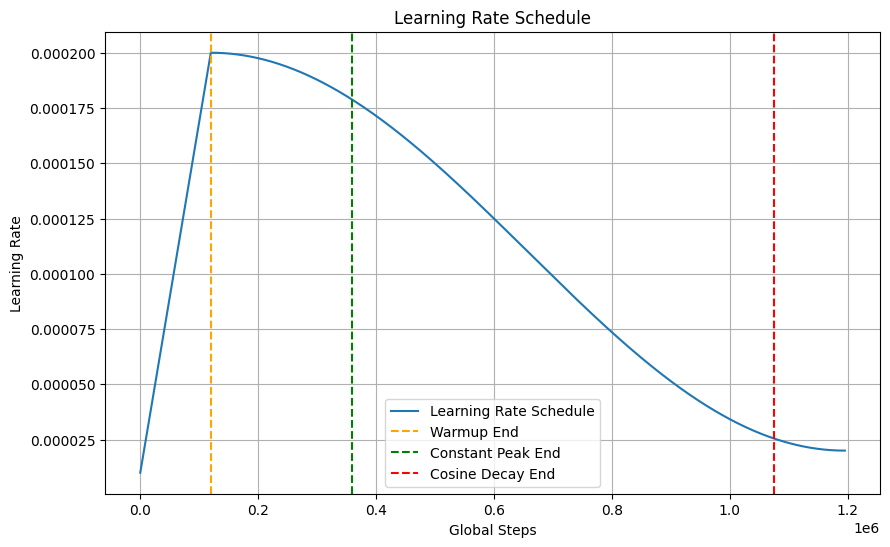

In [ ]:
import math
# Configs
initial_lr = 1e-5
peak_lr = 2e-4
min_lr = 2e-5   # decay 10% of peak


len_train_loader = 4781060
batch_size = 4

# number of total iterations
max_global_steps = len_train_loader/batch_size
print(f'max_global_steps: {max_global_steps}')

# linear warmup steps: 10% of total steps
warmup_steps = .1 * max_global_steps
print(f'warmup_steps:{warmup_steps}')

# constant peak (20%)
peak_steps = 0
peak_steps = warmup_steps + .2 * max_global_steps
print(f'peak_steps: {peak_steps}')

# cosine decay (60%)
cosine_decay_steps = peak_steps + .6 * max_global_steps
print(f'cosine_decay_steps:{cosine_decay_steps}')

# (calclulate initially) Calculate the learning rate increment during the warmup phase
lr_increment = (peak_lr - initial_lr) / warmup_steps
total_training_steps = max_global_steps


def get_lr(initial_lr, global_step, warmup_steps, lr_increment):
    # Adjust the learning rate based on the current phase (warmup or cosine annealing)
    if global_step < warmup_steps:
        # Linear warmup
        lr = initial_lr + global_step * lr_increment  
        return lr
    else:
        # Cosine annealing after warmup
        progress = ((global_step - warmup_steps) / 
                    (total_training_steps - warmup_steps))
        lr = min_lr + (peak_lr - min_lr) * 0.5 * (
            1 + math.cos(math.pi * progress))
        return lr

import matplotlib.pyplot as plt
# Plot the learning rate schedule
global_steps = range(int(max_global_steps))
lr_values = [get_lr(initial_lr, step, warmup_steps, lr_increment) for step in global_steps]

plt.figure(figsize=(10, 6))
plt.plot(global_steps, lr_values, label="Learning Rate Schedule")
plt.axvline(warmup_steps, color="orange", linestyle="--", label="Warmup End")
plt.axvline(peak_steps, color="green", linestyle="--", label="Constant Peak End")
plt.axvline(cosine_decay_steps, color="red", linestyle="--", label="Cosine Decay End")
plt.xlabel("Global Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid()
plt.show()


max_global_steps: 1195265.0
warmup_steps:23905
global_steps:range(0, 1195265)


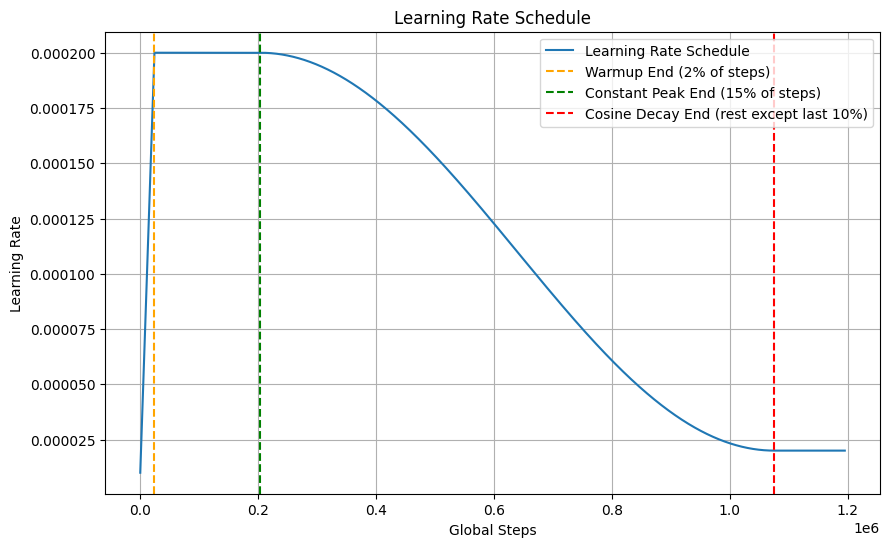

In [ ]:
import math
# Configs
initial_lr = 1e-5
peak_lr = 2e-4
min_lr = 2e-5   # decay 10% of peak


len_train_loader = 4781060
batch_size = 4

# number of total iterations
max_global_steps = len_train_loader/batch_size
print(f'max_global_steps: {max_global_steps}')

# linear warmup steps: 2% of total steps
warmup_steps = int(.02 * max_global_steps)
print(f'warmup_steps:{warmup_steps}')

# constant peak (15% of global steps)
const_peak_steps = warmup_steps + int(.15 * max_global_steps)

# last 10% of steps
const_min_lr_steps = int(.9 * max_global_steps)
# (calclulate initially) Calculate the learning rate increment during the warmup phase
lr_increment = (peak_lr - initial_lr) / warmup_steps
total_training_steps = max_global_steps


def get_lr(initial_lr, min_lr, peak_lr, global_step, warmup_steps, const_peak_steps, lr_increment, const_min_lr_steps):
     # Adjust the learning rate based on the current phase (warmup or cosine annealing)
    # 1) Linear warmup
    if global_step < warmup_steps:
        lr = initial_lr + global_step * lr_increment  
        return lr
    # 2) constant peak larning rate
    elif global_step < const_peak_steps:
        return peak_lr
    # 3) Cosine annealing after constant peak learning rate
    elif global_step < const_min_lr_steps:
        
        progress = ((global_step - const_peak_steps) / (const_min_lr_steps - const_peak_steps)) # modified. to smoothen the curve original: progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
        lr = min_lr + (peak_lr - min_lr) * 0.5 * (
            1 + math.cos(math.pi * progress))
        return lr
    # 4) constant minumum learning rate
    else:
        return min_lr
        

import matplotlib.pyplot as plt
# Plot the learning rate schedule
global_steps = range(int(max_global_steps))
lr_values = [get_lr(initial_lr, min_lr, peak_lr, step, warmup_steps, const_peak_steps, lr_increment, const_min_lr_steps) for step in global_steps]
print(f'global_steps:{global_steps}')

plt.figure(figsize=(10, 6))
plt.plot(global_steps, lr_values, label="Learning Rate Schedule")
plt.axvline(warmup_steps, color="orange", linestyle="--", label="Warmup End (2% of steps)")
plt.axvline(const_peak_steps, color="green", linestyle="--", label="Constant Peak End (15% of steps)")
plt.axvline(const_min_lr_steps, color="red", linestyle="--", label="Cosine Decay End (rest except last 10%)")
plt.xlabel("Global Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid()
plt.show()
